# Foundations of AI & ML
## Session 09
### Experiment 5 - Part 1

In this experiment we will use RNN to classify text one character at a time.
We will be using shakespeare.txt as our input file to the classifier.

The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations.

#### Preparing the data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the unidecode package.

To install the package run the following command


In [1]:
# !pip3 install unidecode

    100% |################################| 235kB 6.0MB/s eta 0:00:01
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
## Importing required packages
import unidecode
import string
import random
import re

In [3]:
all_characters = string.printable
## code to find length of all_characters and storing the value in n_characters
n_characters = len(all_characters)
## code to convert unicode characters into plain ASCII.
file = unidecode.unidecode(open('../Datasets/shakespeare.txt').read())
## code to find length of the file
file_len = len(file)
## printing the length of the file
print('file_len =', file_len)

file_len = 1115393


In [6]:
# print(file[:1000])
# all_characters[:100] # All printable characters!
# string.printable?

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

#### As the string is large, we are going to split it into chunks to provide inputs to the RNN using function random_chunk().

In [7]:
## Initializing the length of chunk
chunk_len = 200
## Function to split the string into chunks
def random_chunk():
    ## Initializing the starting index value of the big string 
    start_index = random.randint(0, file_len - chunk_len)
    ## Initializing the ending index of the string 
    end_index = start_index + chunk_len + 1
    ## returning the chunk
    return file[start_index:end_index]

print(random_chunk())

I had rather had eleven die nobly for their
country than one voluptuously surfeit out of action.

Gentlewoman:
Madam, the Lady Valeria is come to visit you.

VIRGILIA:
Beseech you, give me leave to ret


#### Building the model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al.[1] Their performance on polyphonic music modeling and speech signal modeling was found to be similar to that of long short-term memory. However, GRUs have been shown to exhibit better performance on smaller datasets

In [9]:
###importing required packages
import torch
import torch.nn as nn
from torch.autograd import Variable

### Creating recurrent neural network
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

#### Inputs and targets

Each chunk will be turned into a tensor, specifically a LongTensor (used for integer values), by looping through the characters of the string and looking up the index of each character in all_characters.

In [10]:
# Turn string into list of longs
def char_tensor(string):
    ## tensor is a array
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters up to the last, and the target will be all characters from the first. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [11]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

#### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.



In [16]:
### IAS: Whats going on here?

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp() ### IAS: Whats this????????????????????
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

#### Training

To keep track of how long training takes, we have added a time_since(timestamp) function which returns a human readable string

In [15]:
## Importing required packages
import time, math
## function to print amount of time passed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### The main training function

In [14]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training

In [17]:
n_epochs = 2000 #Number of epochs
print_every = 50
plot_every = 20
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
## Optimizer
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
## Loss function
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

#In this for loop for every 100th iteration we are printing the time taken, loss and the chunk.
for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 7s (50 2%) 2.4894]
Wh chand gne fot liald my

UHYand iseef cord,
Nin
Sand sheapere gu, hear hu od wo lor yowim howe hen f 

 15s (100 5%) 2.2483]
Whath and and by of lomessce moweze von nantt I the Ror harl thom owe mofrd houd gis the Ie fou bly th 

 23s (150 7%) 2.1724]
Whe onom and no lovere hien, comer not I lou soull so o dor the fou do fay fo ray prading I your, of i 

 30s (200 10%) 2.1454]
Whis my ele.

RUCARD
EBe's I is and in will dous to the my shinces no the her or.

RING RIIHAM:

NTARD 

 38s (250 12%) 2.1599]
When, make hatt will, for gater,
I me ant be han thy be thee orle, freen and your be'd the par to ; un 

 46s (300 15%) 2.0421]
Whath mes?

KING RIIY thing may merust me sean respalind sous manes in the he fort,
Thath fore me brak 

 54s (350 17%) 2.1160]
Whly live a I rerinen a the lie,
I waemand ner the wolld sive is slot one he proby to ost home her my  

 1s (400 20%) 1.8147]
Whser fay or me fare for,
And nou sefte to faindelf rotail, sils fore?
O man, lien:
To 

In [13]:
# random_training_set()

#### Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning

Text(0,0.5,'loss')

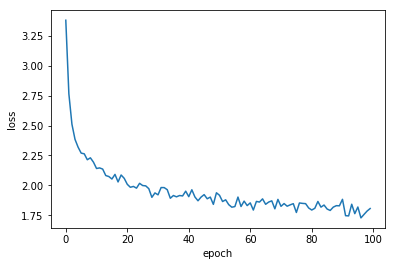

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.xlabel("epoch")
plt.ylabel("loss")

#### Adapting or tuning for prose writing

In the evaluate function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.


We can see the effects of this by adjusting the temperature argument.

In [19]:
print(evaluate('u', 200, temperature=0.8))

utus be speak signe
And let thy lost to you, boy be the's fied
Hall heard the made a pring of the with prood of to this appity
To be gadon's of there sever's the shall seaves save tade of I shall fortu


Lower temperatures are less varied, choosing only the more probable outputs:

In [20]:
print(evaluate('Th', 200, temperature=0.2))

That the shall the shall the son the she should see the shall the should
And the so the shall the shall the shall the she the shall the sone the she she shall the the shall the shall the son.

GLOUCESTE



Higher temperatures more varied, choosing less probable outputs:

In [21]:
print(evaluate('how', 200, temperature=1.4))

how!
Oraflevef, vist tenions, sebie.; your about tigser:
My lorms am Kowby fefcom, likes udoss ForweNef-tilein ifrne,
A ttime tall-burdiengcer, eno'll besiriol
AgL downos, 'I givetmys cam! olds alab my b


# Exercise 1:

Change the number of epochs to 1000. Calculate the time taken and loss.

# Exercise 2:

Change the print every to 50 and plot every to 20. Calculate the time taken and loss and plot the loss graph